In [1]:
!pip install -qU python-gdcm pylibjpeg

In [2]:
import numpy as np
import pandas as pd
import os, random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *
import shutil
import pydicom
import cv2
import glob
import gdcm

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


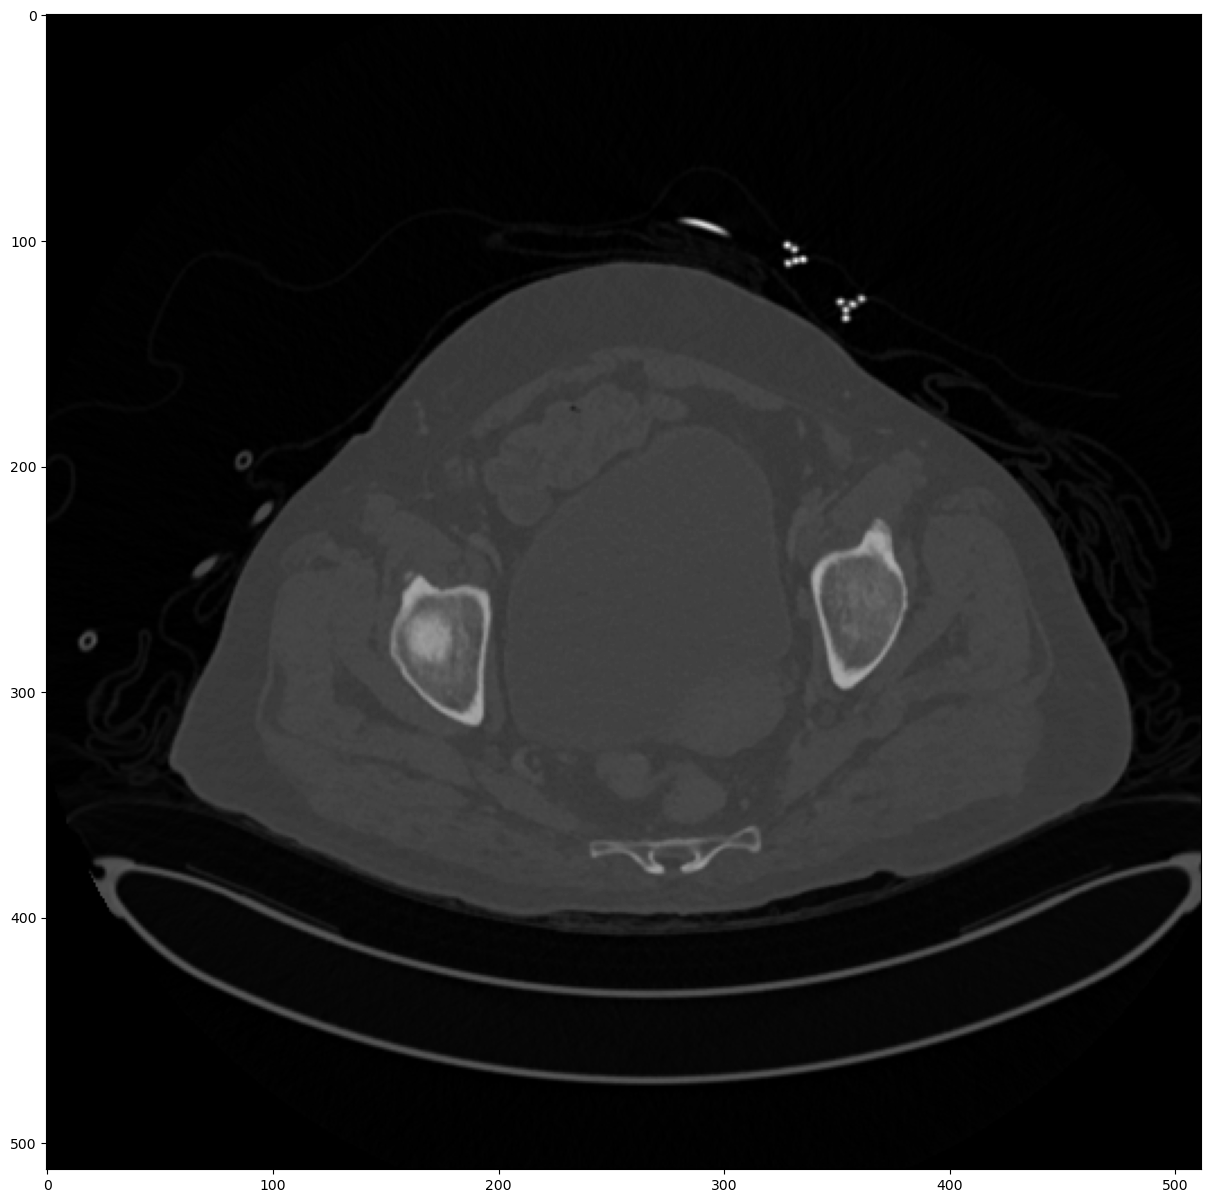

In [3]:
f_dicom = pydicom.dcmread('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/10004/21057/1000.dcm')
img = f_dicom.pixel_array

plt.figure(figsize=(15, 15))
plt.imshow(img, cmap="gray")
plt.show()

In [4]:
f_dicom

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.123.12345.1.2.3.10004.1.1000
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.3.123456.4.5.1234.1.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.123.12345.1.2.3.10004.1.1000
(0008, 0023) Content Date                        DA: '20230721'
(0008, 0033) Content Time                        TM: '232531.265856'
(0010, 0020) Patient ID                          LO: '10004'
(0018, 0050) Slice Thickness                     DS: '1.0'
(0018, 0060) KVP                                 DS: '90.0'
(0018, 5100) Patient Position                    CS: 'HFS'
(002

In [5]:
PARENT_DIR = '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/'
BASE_DIR = '/kaggle/working/rsna-abdominal-trauma-detection-png-pt1_subset/'
if not os.path.exists(BASE_DIR):
    os.makedirs(BASE_DIR)

n_training_samples = 200

subset_files = random.choices(os.listdir(PARENT_DIR), k = n_training_samples)
for x in subset_files:
    shutil.copy(PARENT_DIR + x, BASE_DIR + x)

In [6]:
t = os.listdir(BASE_DIR)

In [7]:
patient_labels = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')
patient_labels.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [8]:
#Check data has no NANs
print(patient_labels.isnull().any().any())
#Check healthy and injury labels are complementary
print((patient_labels['bowel_healthy'] == np.abs(1 - patient_labels['bowel_injury'])).all())
print((patient_labels['extravasation_healthy'] == np.abs(1 - patient_labels['extravasation_injury'])).all())
print((patient_labels['kidney_healthy'] == np.abs(1 - patient_labels['kidney_low'] - patient_labels['kidney_high'])).all())
print((patient_labels['liver_healthy'] == np.abs(1 - patient_labels['liver_low'] - patient_labels['liver_high'])).all())
print((patient_labels['spleen_healthy'] == np.abs(1 - patient_labels['spleen_low'] - patient_labels['spleen_high'])).all())

False
True
True
True
True
True


In [9]:
#Check consistency of any_injury label with respect to other labels
print((patient_labels['any_injury'] == 1 - np.min(patient_labels[['bowel_healthy', 'extravasation_healthy', 
                                                          'kidney_healthy', 'liver_healthy', 'spleen_healthy']], axis = 1)).all())

True


In [10]:
n_scans = 6
random_scans = random.choices(os.listdir(BASE_DIR), k = n_scans)
random_scans = [BASE_DIR + scan for scan in random_scans]

In [11]:
def parse_filename(scan_path):
    file_name = scan_path.split('/')[-1]
    patient_id = file_name.split('_')[0]
    series_id = file_name.split('_')[1]
    frame_num = file_name.split('_')[2][0:-4] # 0:-4 -> get substring without.png extension
    return patient_id, series_id, frame_num
    

/tmp/ipykernel_23/3722233533.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

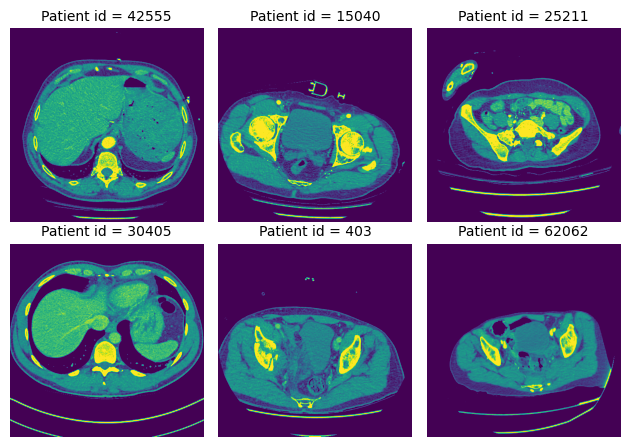

In [12]:
plt.figure()
fig, axs = plt.subplots(ncols = 3, nrows = n_scans//3)

for nrow in range(n_scans//3):
    for ncol in range(3):
        scan_path = random_scans[nrow*3 + ncol]
        img = Image.open(scan_path)
        axs[nrow][ncol].imshow(img)
        
        patient_id, series_id, frame_num = parse_filename(scan_path)
        #txt = 'Patient id = ' + patient_id + ' Series_id = ' + series_id + ' Frame num = ' + frame_num
        txt = 'Patient id = ' + patient_id
        #axs[nrow][ncol].text(0.1, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
        axs[nrow][ncol].set_title(txt, y = 1, fontsize = 10)
        axs[nrow][ncol].set_axis_off()
    plt.tight_layout()

In [13]:
def label_function(f):
        patient_labels = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')
        patient_id = int(f.split('_')[0])
        target_labels = ['bowel_injury', 'extravasation_injury' , 'kidney_healthy' , 'kidney_low' , 'kidney_high', 'liver_healthy', 'liver_low',
                 'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high']
        entry = patient_labels[patient_labels['patient_id'] == patient_id][target_labels]
        return [x for x in target_labels if entry[x].all() == 1] #all() because entry is a dataframe, hence entry[x] is a Series of len 1


In [14]:
filename_labels = pd.DataFrame()
filename_labels['fname'] = pd.Series(os.listdir(BASE_DIR))

In [15]:
x = ['bowel_injury', 'extravasation_injury' , 'kidney_healthy' , 'kidney_low' , 'kidney_high', 'liver_healthy', 'liver_low',
                 'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high']
for idx, t in enumerate(x):
    if 'low' in t or 'high' in t:
        x[idx] = t[0:t.find('_') + 1] + 'injury'
print(list(set(x)))
print(x)

['bowel_injury', 'liver_healthy', 'spleen_injury', 'liver_injury', 'kidney_healthy', 'kidney_injury', 'extravasation_injury', 'spleen_healthy']
['bowel_injury', 'extravasation_injury', 'kidney_healthy', 'kidney_injury', 'kidney_injury', 'liver_healthy', 'liver_injury', 'liver_injury', 'spleen_healthy', 'spleen_injury', 'spleen_injury']


In [16]:
patient_labels = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')
patient_dict = {}
target_labels = ['bowel_injury', 'extravasation_injury' , 'kidney_healthy' , 'kidney_low' , 'kidney_high', 'liver_healthy', 'liver_low',
                 'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high']
reduced_target_labels = ['bowel_injury', 'extravasation_injury' , 'kidney_injury', 'liver_injury', 'spleen_injury']


for idx, patient_id in enumerate(patient_labels['patient_id']):
    entry = patient_labels.iloc[idx][target_labels]
    labels = [x for x in target_labels if entry[x].all() == 1] #all() because entry is a dataframe, hence entry[x] is a Series of len 1
    #If kidney_high or kidney_low, simply replace by kidney_injury. Similarly for liver and spleen.
    reduced_labels = set()
    for idx, lab in enumerate(labels):
        if 'healthy' not in lab:
            if 'low' in lab or 'high' in lab:
                reduced_labels.add(lab[0:lab.find('_') + 1] + 'injury')
            else:
                reduced_labels.add(lab)
    #if not reduced_labels:
    #    reduced_labels = set(['None'])
    #Remove duplicate injury labels (unlikely, due to exclusivity)
    patient_dict[patient_id] = reduced_labels

In [17]:
label_list = []
            
for scan_name in filename_labels['fname']:
    patient_id = int(scan_name.split('_')[0])
    labels = patient_dict[patient_id]
    labels = ' '.join(labels)
    label_list.append(labels)
    
label_list = pd.Series(label_list)
label_list.head()

0                 
1                 
2    spleen_injury
3                 
4                 
dtype: object

In [18]:
filename_labels['labels'] = label_list

In [19]:
filename_labels.head()
filename_labels.shape

(199, 2)

In [20]:
filename_labels

,fname,labels
0,5817_13267_0244.png,
1,37502_53580_0218.png,
2,7369_19713_0331.png,spleen_injury
3,56284_37226_0032.png,
4,25211_53550_0238.png,
...,...,...
194,5817_64103_0304.png,
195,2763_14075_0053.png,
196,21234_5342_0096.png,
197,41956_1418_0011.png,


In [21]:
dls = ImageDataLoaders.from_df(filename_labels, BASE_DIR, folder = '', label_delim = ' ', item_tfms = Resize(224), bs = 64, pin_memory = True, num_workers = 4)

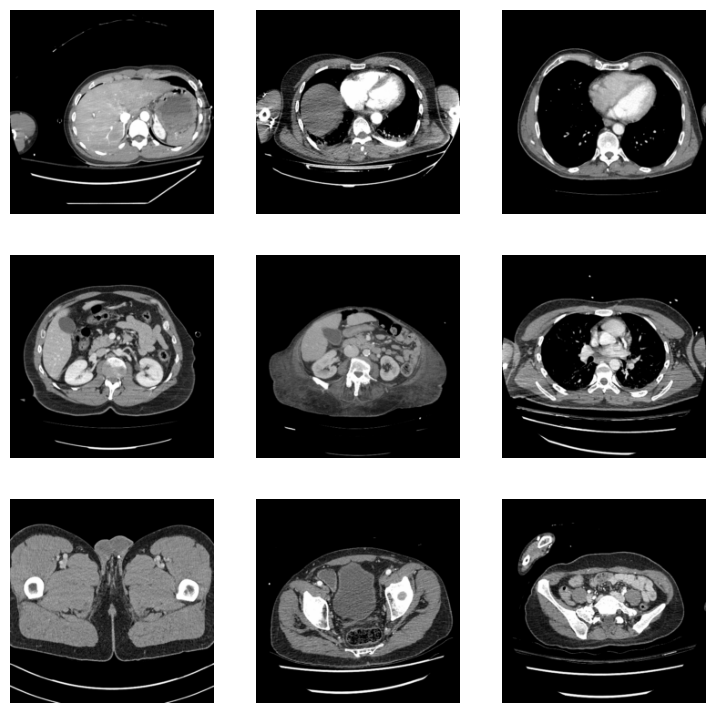

In [22]:
dls.show_batch()

In [23]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
learn = vision_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples], model_dir = '/kaggle/working/models')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 251MB/s]


In [24]:
learn.to_fp16()

In [25]:
#learn.lr_find()

In [26]:
learn.fine_tune(10, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,1.090058,0.613735,0.671795,0.071622,0.051282,00:07


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,0.944829,0.650395,0.656410,0.052991,0.051282,00:04
1,0.949134,0.761176,0.605128,0.126116,0.080342,00:02
2,0.946875,0.866397,0.456410,0.076094,0.052991,00:02
3,0.928460,1.031829,0.374359,0.063094,0.052991,00:02
4,0.913064,1.179643,0.328205,0.084255,0.063858,00:02
5,0.887569,1.219514,0.328205,0.083232,0.063858,00:02
6,0.869370,1.210202,0.317949,0.083053,0.062149,00:02
7,0.846042,1.193072,0.312821,0.084430,0.061111,00:02
8,0.834071,1.152017,0.343590,0.086738,0.061111,00:02
9,0.815839,1.122950,0.384615,0.141080,0.076679,00:02


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


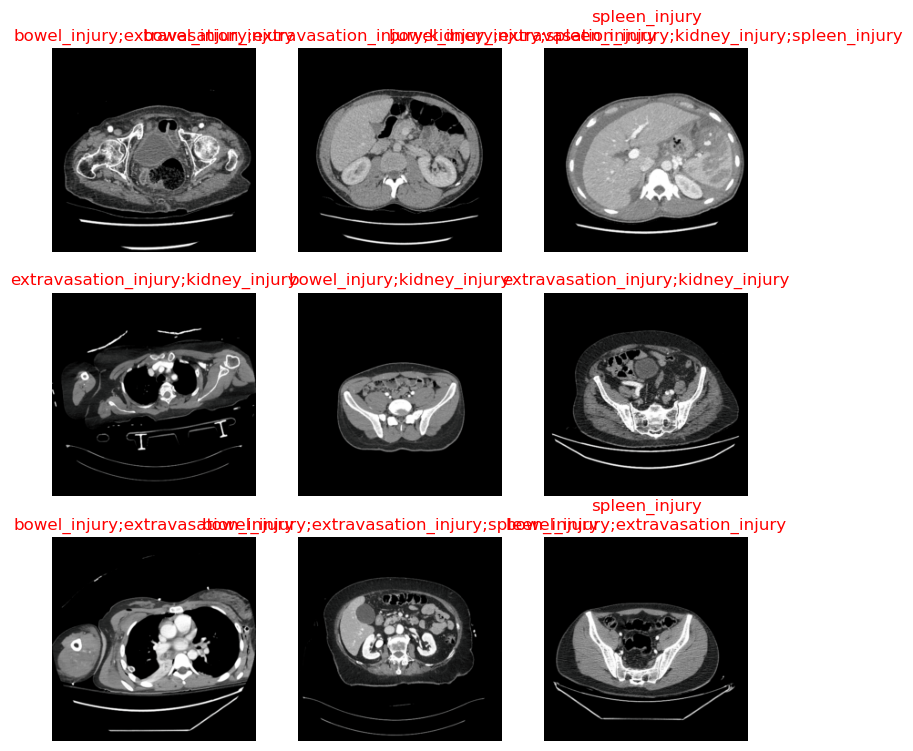

In [27]:
learn.show_results()

In [28]:
learn.export('/kaggle/working/model.pt')